In [ ]:
import numpy as np
import pandas as pd

import matplotlib
from matplotlib import pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.backends.cudnn as cudnn

from torchvision import transforms
from multiprocessing.pool import ThreadPool
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
from torchsummary import summary

from tqdm import tqdm, tqdm_notebook
from PIL import Image
import PIL
from pathlib import Path
import os
from os.path import exists
#import pickle

import warnings
warnings.filterwarnings("ignore")

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [ ]:
torch.manual_seed(42)
np.random.seed(42)

torch.cuda.manual_seed(42)
torch.backends.cudnn.deterministic = True

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [ ]:
def log_progress(sequence, every=1):
    from ipywidgets import IntProgress
    from IPython.display import display

    progress = IntProgress(min=0, max=len(sequence), value=0)
    display(progress)
    
    for index, record in enumerate(sequence):
        if index % every == 0:
            progress.value = index
        yield record

In [ ]:
RESCALE_SIZE = 224
DATA_MODES = ['train', 'val', 'test']

class RemontDataset(Dataset):
    """
    Датасет с картинками, который паралельно подгружает их из папок
    производит скалирование и превращение в торчевые тензоры
    """
    def __init__(self, files, mode):
        super().__init__()
        # список файлов для загрузки
        self.files = sorted(files)
        # режим работы
        self.mode = mode

        if self.mode not in DATA_MODES:
            print(f"{self.mode} is not correct; correct modes: {DATA_MODES}")
            raise NameError

        self.len_ = len(self.files)
     
        self.label_encoder = LabelEncoder()

        if self.mode != 'test':
            self.labels = [path.parent.name for path in self.files]
            self.label_encoder.fit(self.labels)

#            with open('label_encoder.pkl', 'wb') as le_dump_file:
#                  pickle.dump(self.label_encoder, le_dump_file)   
    def __len__(self):
        return self.len_
      
    def load_sample(self, file):
        image = Image.open(file)
        image.load()
        return image
  
    def __getitem__(self, index):
        # для преобразования изображений в тензоры PyTorch и нормализации входа
        transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ])
        transform_train = transforms.Compose([
            transforms.RandomHorizontalFlip(),
            transforms.RandomRotation(25)
        ])

        x = self.load_sample(self.files[index])
        if self.mode == "train":
            x = transform_train(x)
        x = self._prepare_sample(x)
        x = np.array(x / 255, dtype='float32')
        x = transform(x)
        if self.mode == 'test':
            return x
        else:
            label = self.labels[index]
            label_id = self.label_encoder.transform([label])
            y = label_id.item()
            return x, y
        
    def _prepare_sample(self, image):
        image = image.resize((RESCALE_SIZE, RESCALE_SIZE))
        return np.array(image)

In [ ]:
def imshow(inp, title=None, plt_ax=plt, default=False):
    """Imshow для тензоров"""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt_ax.imshow(inp)
    if title is not None:
        plt_ax.set_title(title)
    plt_ax.grid(False)

In [ ]:
train_val_files = []
a = []
for i in range(1, 5):
  TRAIN_DIR = Path('/content/drive/My Drive/Neuro/Train/Train_dataset/' + str(i))
  a.append(list(TRAIN_DIR.glob('*.jpg')))
#TRAIN_DIR = os.listdir('/content/drive/My Drive/Neuro/Train/Train_dataset')
#TEST_DIR = Path('Data/testset/testset')
for b in a:
  for element in b:
    train_val_files.append(element)
train_val_files.sort()
#train_val_files = sorted(list(TRAIN_DIR.glob('*.jpg')))
#test_files = sorted(list(TEST_DIR.rglob('*.jpg')))

In [ ]:
test_files = []
k = []
for i in range(1, 5):
  TEST_DIR = Path('/content/drive/My Drive/Neuro/Train/Train_dataset/' + str(i))
  k.append(list(TRAIN_DIR.glob('*.jpg')))
#TRAIN_DIR = os.listdir('/content/drive/My Drive/Neuro/Train/Train_dataset')
#TEST_DIR = Path('Data/testset/testset')
for j in a:
  for element in j:
    test_files.append(element)
test_files.sort()

In [ ]:
test_files

In [ ]:
train_val_files

In [ ]:
train_val_labels = [path.parent.name for path in train_val_files]
train_files, val_files = train_test_split(train_val_files, test_size=0.25, \
                                          stratify=train_val_labels)

In [ ]:
val_files

In [ ]:
val_dataset = RemontDataset(train_files, mode='val')

In [ ]:
val_dataset

232

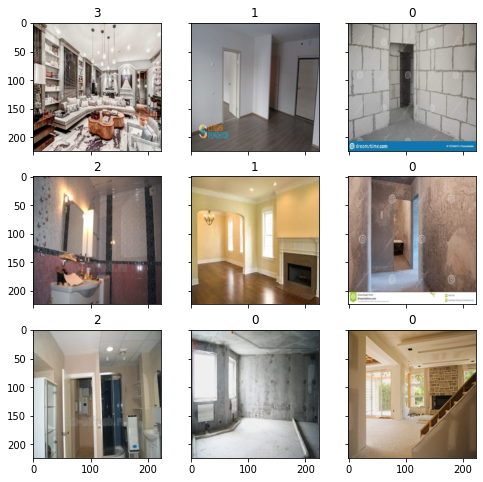

In [ ]:
fig, ax = plt.subplots(nrows=3, ncols=3,figsize=(8, 8), \
                        sharey=True, sharex=True)
for fig_x in ax.flatten():
    random_characters = int(np.random.uniform(0,232))
    im_val, label = val_dataset[random_characters]
    img_label = " ".join(map(lambda x: x.capitalize(),\
                val_dataset.label_encoder.inverse_transform([label])[0].split('_')))
    imshow(im_val.data.cpu(), \
          title=label,plt_ax=fig_x)

Нейроночка

In [ ]:
def predict(model, test_loader):
    with torch.no_grad():
        logits = []
    
        for inputs in test_loader:
            inputs = inputs.to(device)
            model.eval()
            outputs = model.forward(inputs).cpu()
            logits.append(outputs)
            
    probs = nn.functional.softmax(torch.cat(logits), dim=-1).numpy()
    return probs

In [ ]:
def fit_epoch(model, train_loader, criterion, optimizer):
    model.to(device)
    running_loss = 0.0
    running_corrects = 0
    processed_data = 0
  
    for inputs, labels in log_progress(train_loader):
        inputs = inputs.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        preds = torch.argmax(outputs, 1)
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_data += inputs.size(0)
              
    train_loss = running_loss / processed_data
    train_acc = running_corrects.cpu().numpy() / processed_data
    return train_loss, train_acc

In [ ]:
def eval_epoch(model, val_loader, criterion):
    model.to(device)
    model.eval()
    running_loss = 0.0
    running_corrects = 0
    processed_size = 0

    for inputs, labels in val_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        with torch.set_grad_enabled(False):
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            preds = torch.argmax(outputs, 1)

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_size += inputs.size(0)
    val_loss = running_loss / processed_size
    val_acc = running_corrects.double() / processed_size
    return val_loss, val_acc

In [ ]:
def plot_hist(history):
    loss, acc, val_loss, val_acc = zip(*history)
    plt.figure(figsize=(15, 9))
    plt.plot(loss, label="train_loss")
    plt.plot(val_loss, label="val_loss")
    plt.legend(loc='best')
    plt.xlabel("epochs")
    plt.ylabel("loss")
    plt.show()

In [ ]:
def train(train_dataset, val_dataset, model, optim, loss_fn, scheduler, sampler, epochs, batch_size):
    train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=False, sampler=sampler, num_workers=8)
    val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=False, num_workers=8)
    history = []

    best_model = model
    best_acc = 0

    opt = torch.optim.Adam(model.parameters())
    criterion = nn.CrossEntropyLoss()

    for epoch in range(epochs):
        train_loss, train_acc = fit_epoch(model, train_loader, criterion, opt)
            
        val_loss, val_acc = eval_epoch(model, val_loader, criterion)
        history.append((train_loss, train_acc, val_loss, val_acc))

        if val_acc > best_acc:
            best_model = model

        scheduler.step()

        # plot_hist(history)
        print("Epoch " + str(epoch) + ": ", val_acc)
            
    return history, best_model

In [ ]:
train_data = RemontDataset(train_files, "train")
val_data = RemontDataset(val_files, "val")

In [ ]:
num_samples = len(train_data)
labels = train_data.label_encoder.transform(train_data.labels)
class_counts = [0]*4

for i in labels:
    class_counts[i] += 1

class_weights = [num_samples/class_counts[i] for i in range(len(class_counts))]
weights = [class_weights[labels[i]] for i in range(int(num_samples))]

sampler = torch.utils.data.WeightedRandomSampler(torch.DoubleTensor(weights), int(num_samples))

Model

In [ ]:
def get_model():
    Model = torch.hub.load('pytorch/vision:v0.6.0', 'resnet34', pretrained=True)
    Model.fc = nn.Sequential(nn.Linear(512, 42))

    for param in Model.parameters():
        param.requires_grad = False
    for param in Model.fc.parameters():
        param.requires_grad = True
    for param in Model.layer4[2].parameters():
        param.requires_grad = True

    optim = torch.optim.AdamW(Model.parameters(), amsgrad=True)
    loss_fn = nn.CrossEntropyLoss()
    scheduler = torch.optim.lr_scheduler.StepLR(optim, 8, gamma=0.1)

    history, Model = train(train_data, val_data, Model, optim, loss_fn, scheduler, sampler, 32, 256)

    return Model

model_list = []

In [ ]:
model_list.append(get_model())

Downloading: "https://github.com/pytorch/vision/archive/v0.6.0.zip" to /root/.cache/torch/hub/v0.6.0.zip
Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/hub/checkpoints/resnet34-333f7ec4.pth


IntProgress(value=0, max=1)

Epoch 0:  tensor(0.4359, dtype=torch.float64)


IntProgress(value=0, max=1)

Epoch 1:  tensor(0.2692, dtype=torch.float64)


IntProgress(value=0, max=1)

Epoch 2:  tensor(0.4615, dtype=torch.float64)


IntProgress(value=0, max=1)

Epoch 3:  tensor(0.6154, dtype=torch.float64)


IntProgress(value=0, max=1)

Epoch 4:  tensor(0.3333, dtype=torch.float64)


IntProgress(value=0, max=1)

Epoch 5:  tensor(0.5769, dtype=torch.float64)


IntProgress(value=0, max=1)

Epoch 6:  tensor(0.7564, dtype=torch.float64)


IntProgress(value=0, max=1)

Epoch 7:  tensor(0.6795, dtype=torch.float64)


IntProgress(value=0, max=1)

Epoch 8:  tensor(0.5897, dtype=torch.float64)


IntProgress(value=0, max=1)

Epoch 9:  tensor(0.5000, dtype=torch.float64)


IntProgress(value=0, max=1)

Epoch 10:  tensor(0.4359, dtype=torch.float64)


IntProgress(value=0, max=1)

Epoch 11:  tensor(0.5513, dtype=torch.float64)


IntProgress(value=0, max=1)

Epoch 12:  tensor(0.6026, dtype=torch.float64)


IntProgress(value=0, max=1)

Epoch 13:  tensor(0.6923, dtype=torch.float64)


IntProgress(value=0, max=1)

Epoch 14:  tensor(0.7692, dtype=torch.float64)


IntProgress(value=0, max=1)

Epoch 15:  tensor(0.6795, dtype=torch.float64)


IntProgress(value=0, max=1)

Epoch 16:  tensor(0.6410, dtype=torch.float64)


IntProgress(value=0, max=1)

Epoch 17:  tensor(0.6923, dtype=torch.float64)


IntProgress(value=0, max=1)

Epoch 18:  tensor(0.7308, dtype=torch.float64)


IntProgress(value=0, max=1)

Epoch 19:  tensor(0.7692, dtype=torch.float64)


IntProgress(value=0, max=1)

Epoch 20:  tensor(0.7821, dtype=torch.float64)


IntProgress(value=0, max=1)

Epoch 21:  tensor(0.7692, dtype=torch.float64)


IntProgress(value=0, max=1)

Epoch 22:  tensor(0.7308, dtype=torch.float64)


IntProgress(value=0, max=1)

Epoch 23:  tensor(0.7179, dtype=torch.float64)


IntProgress(value=0, max=1)

Epoch 24:  tensor(0.7564, dtype=torch.float64)


IntProgress(value=0, max=1)

Epoch 25:  tensor(0.7821, dtype=torch.float64)


IntProgress(value=0, max=1)

Epoch 26:  tensor(0.7436, dtype=torch.float64)


IntProgress(value=0, max=1)

Epoch 27:  tensor(0.7436, dtype=torch.float64)


IntProgress(value=0, max=1)

Epoch 28:  tensor(0.7564, dtype=torch.float64)


IntProgress(value=0, max=1)

Epoch 29:  tensor(0.7821, dtype=torch.float64)


IntProgress(value=0, max=1)

Epoch 30:  tensor(0.7821, dtype=torch.float64)


IntProgress(value=0, max=1)

Epoch 31:  tensor(0.7692, dtype=torch.float64)


In [ ]:
model_list

In [ ]:
class MyNet(nn.Module):
    def __init__(self, models, out):
        super(MyNet, self).__init__()
        
        self.models = models
        self.out = out
        self.model_n = len(models)
        for model in self.models:
            for param in model.parameters():
                param.requiers_grad = False
        
    def forward(self, x):
        pred_sum = torch.FloatTensor(1, self.out).zero_()

        for i, model in enumerate(self.models):
            pred = model.forward(x).cpu()
            pred = nn.functional.softmax(pred)
            pred_sum = pred_sum + pred

        pred_sum /= self.model_n
        
        return nn.functional.softmax(pred_sum, dim=-1)

In [ ]:
Model = MyNet(model_list, 42)

Вал


In [ ]:
def get_f1_score(model, data):
    val_dataset = RemontDataset(data, "val")
    test_dataset = RemontDataset(data, "test")

    labels = val_dataset.labels
    predicted = predict(model, DataLoader(test_dataset))
    label_encoder = pickle.load(open("label_encoder.pkl", 'rb'))
    predicted = label_encoder.inverse_transform(np.argmax(predicted, axis=1))
    return f1_score(labels, predicted, average="micro")

print(get_f1_score(Model, val_files))

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py", line 2882, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-66-9b28eddf0f93>", line 11, in <module>
    print(get_f1_score(Model, val_files))
  File "<ipython-input-66-9b28eddf0f93>", line 7, in get_f1_score
    label_encoder = pickle.load(open("label_encoder.pkl", 'rb'))
OSError: [Errno 107] Transport endpoint is not connected: 'label_encoder.pkl'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py", line 1823, in showtraceback
    stb = value._render_traceback_()
AttributeError: 'OSError' object has no attribute '_render_traceback_'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/IPython/core/ultr

OSError: ignored

In [ ]:
import os
import pickle

if not os.path.isfile("test_pkl.pkl"):
    with open("test_pkl.pkl",'wb') as file:
        pickle.dump("some obejct", file)

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py", line 2882, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-70-eaa7fe209157>", line 5, in <module>
    with open("test_pkl.pkl",'wb') as file:
OSError: [Errno 107] Transport endpoint is not connected: 'test_pkl.pkl'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py", line 1823, in showtraceback
    stb = value._render_traceback_()
AttributeError: 'OSError' object has no attribute '_render_traceback_'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/IPython/core/ultratb.py", line 1132, in get_records
    return _fixed_getinnerframes(etb, number_of_lines_of_context, tb_offset)
  File "/usr/local/lib/

OSError: ignored